## Required installs/imports


In [1]:
!pip install pure-prng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.7 MB/s eta 0:00:00


In [2]:
# Necessary imports
from pure_prng_package import pure_prng
import numpy as np
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import time

## Classes to provide data generation/evaluation methods

In [3]:
# Class used to access my implmentations of PRNGs
class PRNGManagement():
  # Initialises object and sets the default seed
  def __init__(self, seed=0):
      self.seed = seed
      self.random_number:int = seed
      self.currentGenerator = self.zero_only_PRNG()

  # Method to seed the PRNG (seeds all PRNGs in class)
  def seed_PRNG(self, seed:int):
    self.seed:int = seed
    self.random_number:int = seed

  def set_generator(self, generatorMethod):
    self.currentGenerator = generatorMethod

  def bit_success(self, model, inputData, trueOutputs, sequence_length):
    """ 
    Method to evaluate the provided model and store the amount of
    successful predictions for each bit of the output
    :param model: keras model - Model used to generate predicitions
    :param trueOutputs: list[list[int]]- List containing the expected y outputs
    :param sequence_length: int - Length of generated binary string being predicited
    :return list[int] - Amount of successful predictions for each bit
    """
    # Set initial amount of successful predictions for each bit to zero
    successfulPredicts = [0]*sequence_length
    # Feeds the input data to the model and stores the predictions made
    predicted = (model.predict(inputData).round())
    # Iterate over all outputed data
    for testIndex in range(0, len(inputData)):
      # Iterate over each bit in output
      for i in range(sequence_length):
        # If the predicted bit matches the true bit value then increment the successful predicts for the current bit
        if predicted[testIndex][i] == trueOutputs[testIndex][i]: successfulPredicts[i] += 1
        # Prediction may be greater than 1 if the prediction is made with high certainity
        elif predicted[testIndex][i] > 1 and trueOutputs[testIndex][i] == 1: self.successfulPredicts[i] += 1

    return successfulPredicts
   

  def zero_only_PRNG(self, length=100):
    """ 
    Returns a binary string containing only 0 of specified length.
    Used to test for major flaws in models
    :param length: int - Length of generated binary string
    :return string - generated binary string
    """
    return "0" * length        


  def alternating_bits_PRNG(self, length=100):
    """ 
    Returns output of a basic PRNG implementation that alernates each bit (010101)
    :param length: int - Length of generated binary string
    :return string - generated binary string
    """
    # Use seed to determine the starting bit of the generated binary string
    self.seed = self.seed%2
    # Utilises efficent method to repeat a string pattern
    if (self.seed == 1):
        output = "10" * int(length/2)
    else:
        output = "01" * int(length/2)

    # Length of generated binary string is odd
    if (length%2 == 1):
      # Add final bit to string
      output += str(self.seed)
      # Set the new seed value
      if (self.seed == 0): self.seed = 1
      else: self.seed = 0
    
    return output


  def alternating_num_PRNG(self):
    """ 
    Returns output of a basic PRNG implementation that alernates between two binary strings
    :return string - generated binary string
    """
    # Use seed to determine the binary string to be returned
    self.seed = (self.seed+1)%2
    if (self.seed == 0):
      # Convert integer to a binary string 
      randomBinary = str(bin(1643712566))[2:]
      # Returns binary string after ensuring a minimum length of 32
      return (32-len(randomBinary))*"0" + randomBinary
    else:
      # Convert integer to a binary string 
      randomBinary = str(bin(2372817037))[2:]
      # Returns binary string after ensuring a minimum length of 32
      return (32-len(randomBinary))*"0" + randomBinary


  def basic_equation_based(self, mult:int, add:int, mod:int, leng:int) -> str:
    """ 
    Returns output of a very weak equation based PRNG implementation
    Expected to be predicted near perfectly
    :return string - generated binary string
    """
    # Generates random number using previous output as seed
    self.random_number = (mult * self.random_number + add) % mod
    # Converts generated number to a binary string
    bits_string = bin(self.random_number)[2:]
    # Returns binary string after using padding to ensure a length of 32
    return bits_string.zfill(leng)


  ## Different implmentations of equation based generators
  def basic_equation_based1(self) -> str:
    return self.basic_equation_based(20, 52, 2**32, 32)

  def basic_equation_based2(self) -> str:
    return self.basic_equation_based(36791, 83247, 2**32, 32)

  # Expects odd starting seed
  # Imeplementation of the PRNG 'RANDU' - Outdated PRNG
  def RANDU(self) -> str:
    return self.basic_equation_based(65539, 0, 2**31, 31)

  # Implementation of the Park Miller PRNG - Outdated PRNG
  def Park_Miller(self) -> str:
    return self.basic_equation_based(16807, 0, 2**31-1, 32)

  # Get stream of binary data form current generator
  def get_stream(self, number_of_blocks:int):
    stream = []
    for _ in range(number_of_blocks):
      # Converts generated binary string to list of ints
      block = [int(bit) for bit in self.currentGenerator()] 
      stream.extend(block)
    return stream

In [4]:
# Class used to manage the PRNGs offered by the PRNG library
class PRNGLibManagement():
  def __init__(self, PRNGType:str, outputLen:int):
    self.change_PRNG(PRNGType, outputLen)

  # Change the type of the current PRNG
  def change_PRNG(self, PRNGType:str, outputLen:int):
    self.outputLen = outputLen
    self.PRNGType = PRNGType
    self.currentGen = pure_prng(int(time.time()), prng_type=PRNGType).source_random_number()

  # Seed the current PRNG
  def seed_current(self, seed=int(time.time())):
    self.currentGen = pure_prng(int(seed), prng_type=self.PRNGType).source_random_number()

  # Generates an output from the curent PRNG
  def output_current(self):
    # Converts generated number to a binary string
    bits_string = bin(next(self.currentGen))[2:]
    # Returns binary string after using padding to ensure a consistent length
    return bits_string.zfill(self.outputLen)

  # Generates output from current PRNG as a list containing the integer bits
  def next_ints(self):
    # Converts generated binary string to list of ints
    return [int(bit) for bit in self.output_current()] 

  # Get stream of binary data form current generator
  def get_stream(self, number_of_blocks:int):
    stream = []
    for _ in range(number_of_blocks):
      block = self.next_ints()
      stream.extend(block)
    return stream

## Data generation function to be used during data production

In [5]:
# Creates object to use the 'Ran64' PRNG
PRNGLibHandler = PRNGLibManagement("Ran64", 64)
#
PRNGHandler = PRNGManagement(1)
PRNGHandler.set_generator(PRNGHandler.Park_Miller)

def generatorOutput(blockNum): return PRNGHandler.get_stream(blockNum)
def seedGenerator(seed): PRNGHandler.seed_PRNG(seed)

## Setting parameters for data generation

In [22]:
### Setting parameters
# Sets paramemters for generating train/test data
num_blocks = 20000
sequence_length = 32

# Number of samples must be a multiple of 100 to prevent an error
num_samples = (num_blocks-1)*sequence_length

print("Number of samples: ", num_samples)

Number of samples:  639968


In [23]:
# Seed generator
seedGenerator(23)
# Get stream data 
streamData = generatorOutput(num_blocks)

# Stores output in variable to allow the sample to be featued in both x and y data
X_data, Y_data = [], []

# Extracts stream data samples
for i in range(num_samples):
  X_data.append(streamData[i:i+sequence_length])
  Y_data.append([streamData[i+sequence_length]])

# Deletes stream data to save memory
del streamData

In [24]:
### Separate data into training/testing sets
# Percentage of data used for testing the created prediction model
testDataPerc = 0.2

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = testDataPerc, random_state = 5)

del X_data
del Y_data

## Creation and taining of different models

#### Dense + Normalisation + Dropout

In [9]:
# Sets parameters for model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.1))
  model.add(BatchNormalization())
  model.add(Dense(sequence_length//2, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

In [10]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2560/2560 [==============================] - 34s 10ms/step - loss: 0.6999 - accuracy: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.5097
Epoch 2/10
2560/2560 [==============================] - 17s 7ms/step - loss: 0.6926 - accuracy: 0.5159 - val_loss: 0.6929 - val_accuracy: 0.5105
Epoch 3/10
2560/2560 [==============================] - 17s 7ms/step - loss: 0.6924 - accuracy: 0.5174 - val_loss: 0.6928 - val_accuracy: 0.5138
Epoch 4/10
2560/2560 [==============================] - 16s 6ms/step - loss: 0.6922 - accuracy: 0.5174 - val_loss: 0.6927 - val_accuracy: 0.5100
Epoch 5/10
2560/2560 [==============================] - 16s 6ms/step - loss: 0.6921 - accuracy: 0.5187 - val_loss: 0.6930 - val_accuracy: 0.5123
Epoch 6/10
2560/2560 [==============================] - 17s 7ms/step - loss: 0.6919 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5109
Epoch 7/10
2560/2560 [==============================] - 17s 7ms/step - loss: 0.6919 - accuracy: 0.5208 - val_loss: 0.6932 - val_a

In [11]:
model.save("ParkMillerDND1.h5")

#### Long Short-Term Memory

In [12]:
# Sets parameters for model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(LSTM(int(sequence_length), input_shape=(sequence_length, 1), return_sequences=True))
  model.add(LSTM(int(sequence_length/1.5), return_sequences=True))
  model.add(LSTM(int(sequence_length/2)))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

  model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32, 21)            4536      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2432      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,337
Trainable params: 11,337
Non-trainable params: 0
_________________________________________________________________


In [13]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2560/2560 [==============================] - 41s 13ms/step - loss: 0.6927 - accuracy: 0.5159 - val_loss: 0.6930 - val_accuracy: 0.5119
Epoch 2/10
2560/2560 [==============================] - 26s 10ms/step - loss: 0.6927 - accuracy: 0.5162 - val_loss: 0.6929 - val_accuracy: 0.5119
Epoch 3/10
2560/2560 [==============================] - 26s 10ms/step - loss: 0.6926 - accuracy: 0.5161 - val_loss: 0.6929 - val_accuracy: 0.5119
Epoch 4/10
2560/2560 [==============================] - 26s 10ms/step - loss: 0.6926 - accuracy: 0.5162 - val_loss: 0.6929 - val_accuracy: 0.5119
Epoch 5/10
2560/2560 [==============================] - 29s 11ms/step - loss: 0.6926 - accuracy: 0.5162 - val_loss: 0.6930 - val_accuracy: 0.5119
Epoch 6/10
2560/2560 [==============================] - 26s 10ms/step - loss: 0.6926 - accuracy: 0.5162 - val_loss: 0.6929 - val_accuracy: 0.5119
Epoch 7/10
2560/2560 [==============================] - 26s 10ms/step - loss: 0.6926 - accuracy: 0.5162 - val_loss: 0.6929 -

In [14]:
model.save("ParkMillerLTSM1.h5")

#### Conv1d

In [15]:
# Sets parameters for produced model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length,1)))
  model.add(Flatten())
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           512       
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                122912    
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 123,457
Trainable params: 123,457
Non-trainable params: 0
_________________________________________________________________


In [16]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2560/2560 [==============================] - 26s 8ms/step - loss: 0.6925 - accuracy: 0.5157 - val_loss: 0.6926 - val_accuracy: 0.5132
Epoch 2/10
2560/2560 [==============================] - 12s 5ms/step - loss: 0.6922 - accuracy: 0.5161 - val_loss: 0.6929 - val_accuracy: 0.5119
Epoch 3/10
2560/2560 [==============================] - 11s 4ms/step - loss: 0.6921 - accuracy: 0.5168 - val_loss: 0.6929 - val_accuracy: 0.5124
Epoch 4/10
2560/2560 [==============================] - 11s 4ms/step - loss: 0.6921 - accuracy: 0.5176 - val_loss: 0.6930 - val_accuracy: 0.5105
Epoch 5/10
2560/2560 [==============================] - 12s 5ms/step - loss: 0.6921 - accuracy: 0.5171 - val_loss: 0.6928 - val_accuracy: 0.5126
Epoch 6/10
2560/2560 [==============================] - 13s 5ms/step - loss: 0.6920 - accuracy: 0.5167 - val_loss: 0.6928 - val_accuracy: 0.5113
Epoch 7/10
2560/2560 [==============================] - 12s 5ms/step - loss: 0.6920 - accuracy: 0.5173 - val_loss: 0.6933 - val_ac

In [17]:
model.save("ParkMillerConv1D1.h5")

#### Conv1d + Normalisation + Dropout

In [25]:
# Sets parameters for produced model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length,1)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.1))
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 30, 128)           512       
                                                                 
 flatten_2 (Flatten)         (None, 3840)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 3840)             15360     
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 3840)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                122912    
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                      

In [26]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
5120/5120 [==============================] - 47s 9ms/step - loss: 0.6971 - accuracy: 0.5108 - val_loss: 0.6927 - val_accuracy: 0.5154
Epoch 2/10
5120/5120 [==============================] - 31s 6ms/step - loss: 0.6926 - accuracy: 0.5148 - val_loss: 0.6922 - val_accuracy: 0.5173
Epoch 3/10
5120/5120 [==============================] - 30s 6ms/step - loss: 0.6924 - accuracy: 0.5160 - val_loss: 0.6923 - val_accuracy: 0.5193
Epoch 4/10
5120/5120 [==============================] - 31s 6ms/step - loss: 0.6898 - accuracy: 0.5355 - val_loss: 0.6775 - val_accuracy: 0.5837
Epoch 5/10
5120/5120 [==============================] - 31s 6ms/step - loss: 0.6620 - accuracy: 0.5975 - val_loss: 0.6415 - val_accuracy: 0.6266
Epoch 6/10
5120/5120 [==============================] - 30s 6ms/step - loss: 0.6372 - accuracy: 0.6420 - val_loss: 0.6215 - val_accuracy: 0.6831
Epoch 7/10
5120/5120 [==============================] - 31s 6ms/step - loss: 0.6227 - accuracy: 0.6745 - val_loss: 0.6061 - val_ac

In [28]:
model.save("ParkMillerCND1.h5")

#### Graphing current model history

Plotting graph


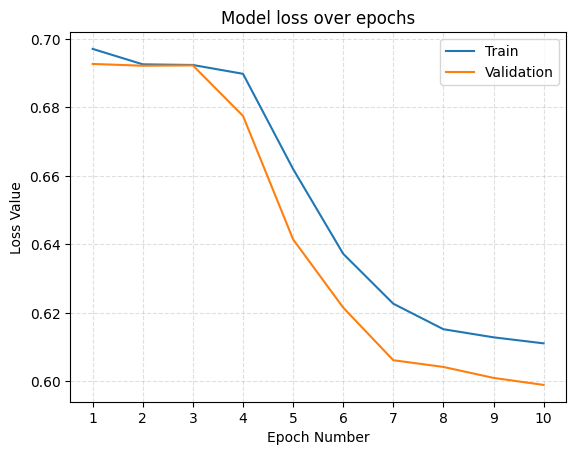

In [29]:
print("Plotting graph")
# Plot training & validation loss values
# Plots loss data
plt.plot(range(1, epochs+1), history.history['loss'])
plt.plot(range(1, epochs+1), history.history['val_loss'])
# Plots a label for each axis
plt.ylabel('Loss Value')
plt.xlabel('Epoch Number')
# Plots the title
plt.title('Model loss over epochs')
# Plots the legend for each loss
plt.legend(['Train', 'Validation'], loc='upper right')

# Sets grid for plot
plt.grid(linestyle='--', alpha=0.4)
# Ensures the x-axis only contains integers
plt.xticks(range(1, epochs+1))


# Displays plot
plt.show()
